# Интеллектуальный анализ данных – весна 2022

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [13]:
k1 = 8
k2 = 2
p1 = k1/(k1+k2)
p2 = k2/(k1+k2)
H_entrp = - p1*np.log(p1) - p2*np.log(p2)
print(round(H_entrp, 2))

0.5


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [14]:

H_jinl = p1*(1-p1)
H_jinr = p2*(1-p2)
H_jin = H_jinl + H_jinr

Q = H_jin 
print(round(Q, 2))

0.32


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [15]:
# для регрессии просто среднее считаем
print(np.mean( [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] ))

40.6


## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [16]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

Эту функцию можно протестировать на датасете `California`.

In [22]:
from sklearn.datasets import fetch_california_housing

In [23]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [24]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    def gini(y):
        p = np.sum(y)/y.shape[0]
        p0 = 1.0 - p
        return 1 - p0**2 - p**2
    
    def mse(y):
        return np.sum((y - np.mean(y))**2)


    def impurity(task, f_type, X, y, threshold):
        if f_type == "real":
            split = np.array(X <= threshold)
        else:
            split = np.array(X == threshold)
        l = y[split]
        r = y[np.logical_not(split)]
        if task == "regression":
            l_cr, r_cr = mse(l), mse(r)
        else:
            l_cr, r_cr = gini(l), gini(r)
        return - l.shape[0] / y.shape[0] * l_cr - r.shape[0] / y.shape[0] * r_cr
    id = np.argsort(feature_vector)
    feature_vector = feature_vector[id]
    target_vector = target_vector[id]
    thresholds, ginis, threshold_best, impurity_best = [], [], -1, -np.inf
    for i in range(feature_vector.shape[0]):   
        if feature_type == "real":
            if i == feature_vector.shape[0] - 1:
                break
            # проверка, что все не улетело в один узел
            mean = (feature_vector[i] + feature_vector[i+1]) / 2
            q = feature_vector <= mean
            if (target_vector[q].shape[0] == 0) or (target_vector[~q].shape[0] == 0):
                continue
        else:
            mean = feature_vector[i]
            q = feature_vector == mean
            if (target_vector[q].shape[0] == 0) or (target_vector[~q].shape[0] == 0):
                continue
        impur = impurity(task, feature_type, feature_vector, target_vector, mean)
        thresholds.append(mean)
        ginis.append(impur)
        if impur > impurity_best:
            threshold_best, impurity_best = mean, impur
    return thresholds, ginis, threshold_best, impurity_best
     
thresholds, variances, threshold_best, variance_best = find_best_split(
    X["MedInc"].to_numpy(), 
    y, 
    task="regression",
    feature_type="real"
)
   

In [25]:
thresholds, variances, threshold_best, variance_best = find_best_split(
    X["MedInc"].to_numpy(), 
    y, 
    task="regression",
    feature_type="real"
)

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

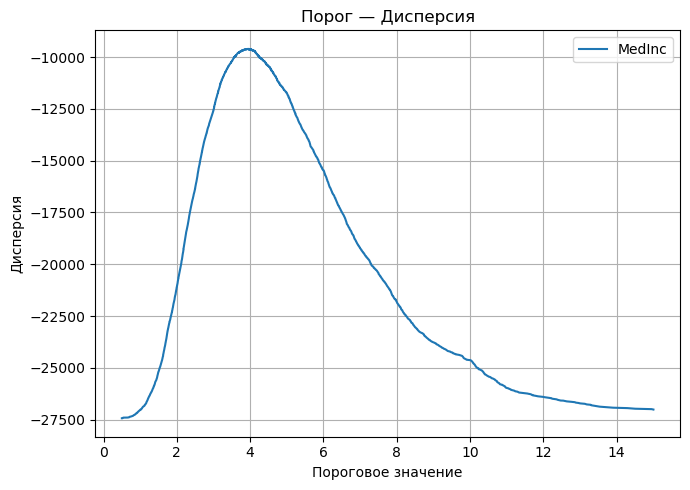

In [26]:
plt.figure(figsize=(7, 5))
plt.plot(thresholds, variances, label="MedInc")
plt.grid()
plt.legend()
plt.xlabel("Пороговое значение")
plt.ylabel("Дисперсия")
plt.title("Порог — Дисперсия")
plt.tight_layout()
plt.show()

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [72]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [27]:
class DecisionTree:
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        #А вот они (2 следующие строчки) тут чтобы были? :)
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}


            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                feature_vector = sub_X[:, feature]

            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

             
                if feature_type == "real":
                    threshold_best = threshold
                    split = np.array(feature_vector <= threshold_best)
                elif feature_type == "categorical":
                    threshold_best = threshold
                    split = np.array(feature_vector == threshold_best)
                else:
                    raise ValueError

      
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"
        
        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node["type"] == "terminal":
            return node["class"]
        feature_type = self._feature_types[node["feature_split"]]
        if feature_type == "real":
            if x[node["feature_split"]] <= node["threshold"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        else:
            if x[node["feature_split"]] == node["category_split"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [28]:
df = pd.read_csv("students.csv")
X = df[["STG", "SCG", "STR", "LPR", "PEG"]]
y = df["UNS"]
df.head()

,Unnamed: 0,STG,SCG,STR,LPR,PEG,UNS
0,0,0.00,0.00,0.00,0.00,0.00,0
1,1,0.08,0.08,0.10,0.24,0.90,1
2,2,0.06,0.06,0.05,0.25,0.33,0
3,3,0.10,0.10,0.15,0.65,0.30,1
4,4,0.08,0.08,0.08,0.98,0.24,0


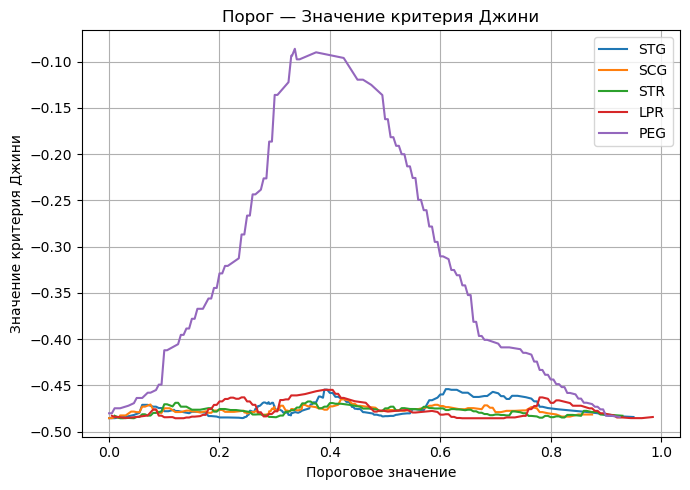

In [29]:
plt.figure(figsize=(7, 5))
for i in X.columns:
    thresholds, variances, _, _ = find_best_split(
    X[i].to_numpy(), 
    y, 
    task="classification",
    feature_type="real")
    plt.plot(thresholds, variances, label=i)
plt.grid()
plt.legend()
plt.xlabel("Пороговое значение")
plt.ylabel("Значение критерия Джини")
plt.title("Порог — Значение критерия Джини")
plt.tight_layout()
plt.show()

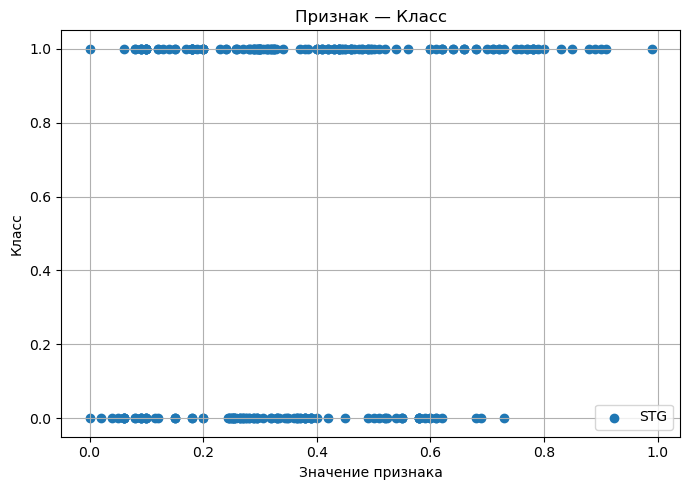

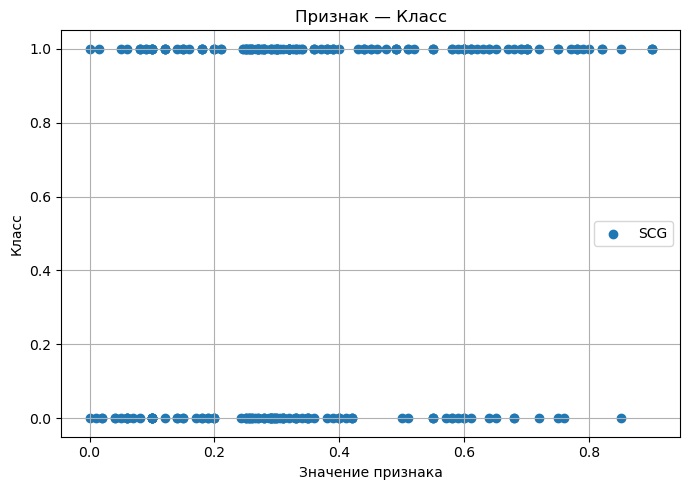

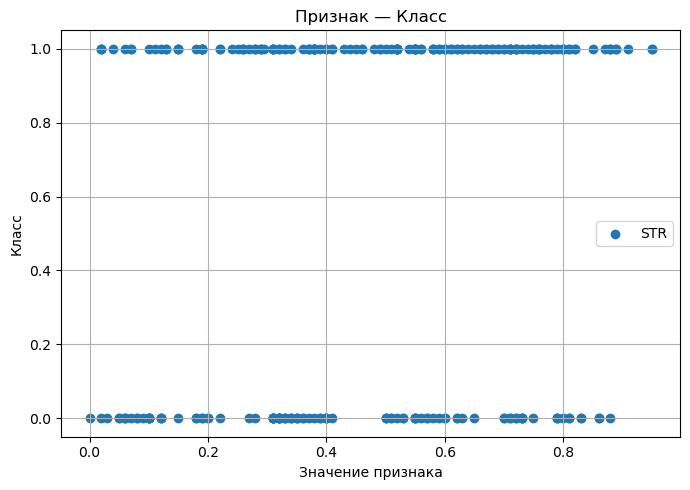

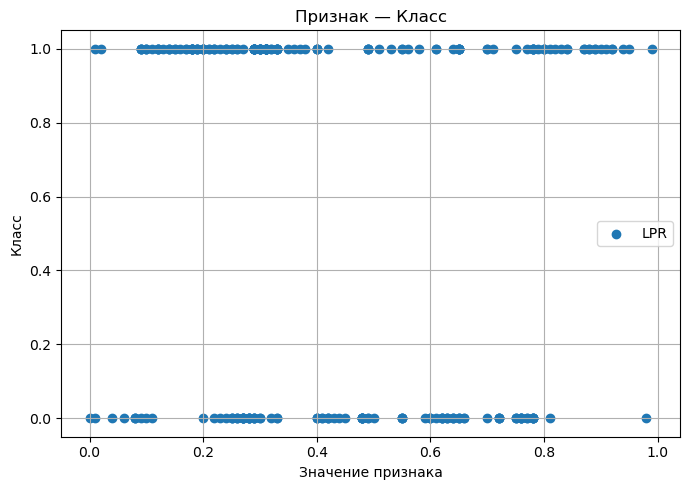

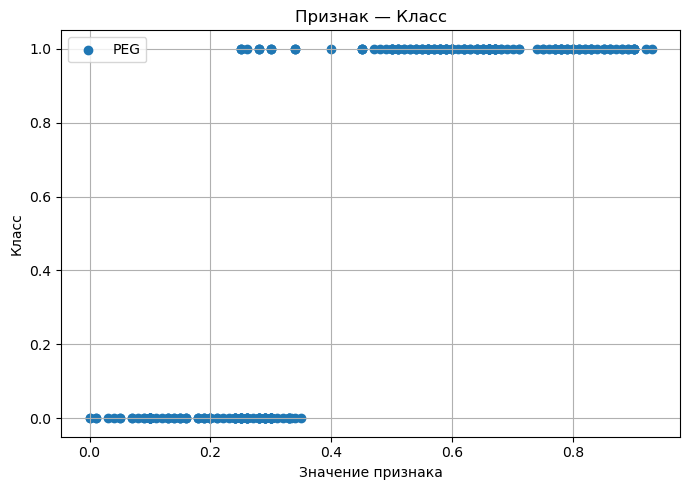

In [30]:
for i in X.columns:
    plt.figure(figsize=(7, 5))
    plt.scatter(X[i], y, label=i)
    plt.grid()
    plt.legend()
    plt.xlabel("Значение признака")
    plt.ylabel("Класс")
    plt.title("Признак — Класс")
    plt.tight_layout()
    plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

по PEG. C визуальной оценкой согласуется, да. Для хороших признаков вид кривой напоминает параболу, для плохих, по которым деление нельзя провести - они больше похожи на прямую. Все будет плохо, потому что там как ни дели, критерий Джини не изменится.

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [36]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
df = pd.read_csv("agaricus-lepiota.data", header=None)
le = sklearn.preprocessing.LabelEncoder()

In [37]:

y = df[0]
le.fit(y)
y = le.transform(y)
X = df.drop(df.columns[0],axis = 1)
for i in X.columns:
    le.fit(X[i])
    X[i] = le.transform(X[i])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
types = np.full(X.shape[1], "categorical")
tr = DecisionTree(types)
tr.fit(X_train.to_numpy(), y_train)
y_test_pred = tr.predict(X_test.to_numpy())
accuracy_score(y_test, y_test_pred)

1.0

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [75]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [76]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

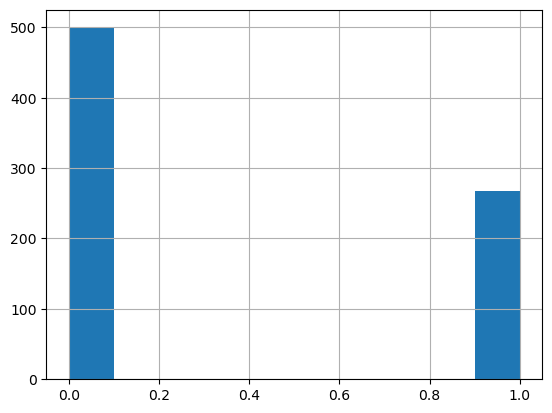

In [77]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [78]:
columns = data.columns
mask = np.ones(columns.shape, dtype=bool)
mask[8] = 0
X = data[columns[mask]]
y = data[columns[8]]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)



**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [100]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score


max_depth = np.array([10, 20, 15, 40])
min_samples_leaf = np.array([2, 15, 20, 30])
for j in range(max_depth.shape[0]):
    for i in range(max_depth.shape[0]):
        clf = DecisionTreeClassifier(max_depth= max_depth[j], min_samples_leaf= min_samples_leaf[i])
        clf.fit(X_train_train, y_train_train)
        y_train_val_pred = clf.predict(X_train_val)
        print("min_samples:", min_samples_split[i], "  ", "max_depth:", max_depth[j], "  ", f1_score(y_train_val_pred, y_train_val))
        



min_samples: 2    max_depth: 10    0.6213592233009709
min_samples: 15    max_depth: 10    0.5617977528089887
min_samples: 20    max_depth: 10    0.5617977528089887
min_samples: 30    max_depth: 10    0.5531914893617021
min_samples: 2    max_depth: 20    0.5825242718446603
min_samples: 15    max_depth: 20    0.5617977528089887
min_samples: 20    max_depth: 20    0.5617977528089887
min_samples: 30    max_depth: 20    0.5531914893617021
min_samples: 2    max_depth: 15    0.5882352941176471
min_samples: 15    max_depth: 15    0.5617977528089887
min_samples: 20    max_depth: 15    0.5617977528089887
min_samples: 30    max_depth: 15    0.5531914893617021
min_samples: 2    max_depth: 40    0.536082474226804
min_samples: 15    max_depth: 40    0.5617977528089887
min_samples: 20    max_depth: 40    0.5617977528089887
min_samples: 30    max_depth: 40    0.5531914893617021


In [101]:
clf = DecisionTreeClassifier(max_depth = 10, min_samples_leaf= 2)
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print('accuracy: ',accuracy_score(y_test_pred, y_test))
print('prescision: ',precision_score(y_test_pred, y_test))
print('recall:', recall_score(y_test_pred, y_test))
print('auc-roc:', roc_auc_score(y_test_pred, y_test))



accuracy:  0.7142857142857143
prescision:  0.675
recall: 0.574468085106383
auc-roc: 0.6923435316042864


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [102]:
bg = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)
bg.fit(X_train, y_train)
res = bg.predict(X_test)
print("Accuracy:", accuracy_score(y_test, res))
print("Precision:", precision_score(y_test, res))
print("Recall:", recall_score(y_test, res))
print("AUC-ROC:", roc_auc_score(y_test, res))

Accuracy: 0.7489177489177489
Precision: 0.6309523809523809
Recall: 0.6625
AUC-ROC: 0.7286009933774835


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [105]:
max_depth = np.array([10, 20, 15, 40])
min_samples_leaf = np.array([2, 15, 20, 30])
for j in range(max_depth.shape[0]):
    for i in range(max_depth.shape[0]):
            tr  = RandomForestClassifier(n_estimators= 50, max_depth= max_depth[j], 
                min_samples_split= min_samples_split[i])
            cr_v = cross_val_score(tr,X_train,y_train, cv = 3, scoring = 'f1')
            print("min_samples: ", min_samples_split[i], "max_depth:", max_depth[j], cr_v.mean())



min_samples:  2 max_depth: 10 0.6530067562415166
min_samples:  15 max_depth: 10 0.6476586052120318
min_samples:  20 max_depth: 10 0.622992666852316
min_samples:  30 max_depth: 10 0.6116466934018411
min_samples:  2 max_depth: 20 0.6569171541422928
min_samples:  15 max_depth: 20 0.6586790353576951
min_samples:  20 max_depth: 20 0.6587449518484001
min_samples:  30 max_depth: 20 0.6193392822570709
min_samples:  2 max_depth: 15 0.6311972778554056
min_samples:  15 max_depth: 15 0.6473762210904234
min_samples:  20 max_depth: 15 0.6532012635155753
min_samples:  30 max_depth: 15 0.6040722976833676
min_samples:  2 max_depth: 40 0.6270894627874033
min_samples:  15 max_depth: 40 0.6218117758163525
min_samples:  20 max_depth: 40 0.6404700216225075
min_samples:  30 max_depth: 40 0.6009862840009457


In [108]:
tr = RandomForestClassifier(n_estimators= 50, max_depth= 20, min_samples_split= 20)
tr.fit(X_train, y_train)
y_test_pred = tr.predict(X_test)

print('accuracy: ',accuracy_score(y_test_pred, y_test))
print('prescision: ',precision_score(y_test_pred, y_test))
print('recall:', recall_score(y_test_pred, y_test))
print('auc-roc:', roc_auc_score(y_test_pred, y_test))

accuracy:  0.7489177489177489
prescision:  0.625
recall: 0.6410256410256411
auc-roc: 0.722473604826546


**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

In [111]:
n = np.array([2,5,10, 15, 20, 25, 50, 100, 175, 200,  250, 300, 350, 400, 450, 500, 600, 700, 800, 825, 850, 900, 1000, 1100, 1200])
auc_roc=np.zeros(n.shape[0])
for j in range(n.shape[0]):
    tr = RandomForestClassifier(n_estimators=n[j], min_samples_split= 20, random_state=42)
    tr.fit(X_train, y_train)
    y_test_pred= tr.predict(X_test)
    auc_roc[j] = (roc_auc_score(y_test, y_test_pred))

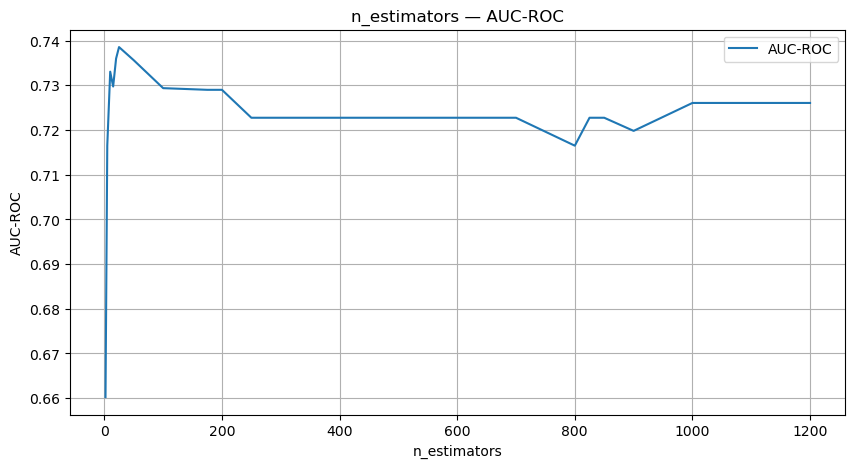

In [115]:
plt.figure(figsize=(10, 5))
plt.plot(n, auc_roc, label="AUC-ROC")
plt.grid()
plt.legend()
plt.ylabel("AUC-ROC")
plt.xlabel("n_estimators")
plt.title("n_estimators — AUC-ROC")
plt.show()

Выовод: больше 50-70 деревьев брать смысла нет, меньше примерно 10 тоже.

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

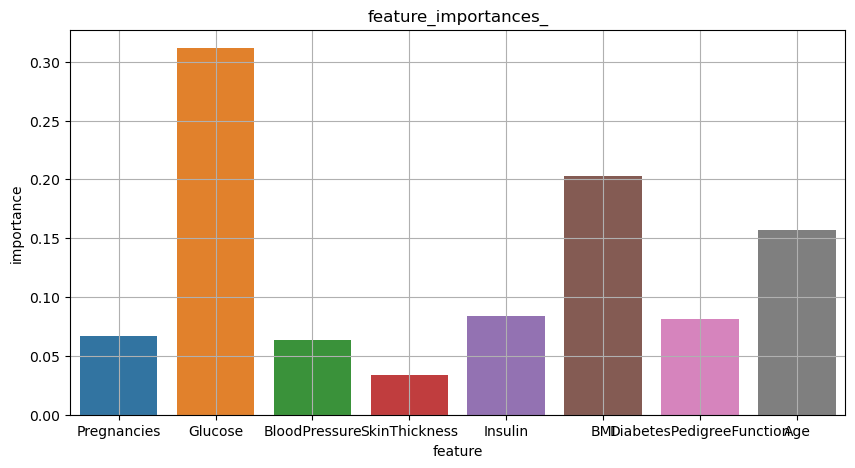

In [114]:
import seaborn as sns
tr = RandomForestClassifier(n_estimators= 20, min_samples_split=20, max_depth= 20, random_state=42)
tr.fit(X_train, y_train)
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=X.columns, y=tr.feature_importances_)
ax.set_xlabel("feature")
ax.set_ylabel("importance")
ax.set_title("feature_importances_")
plt.grid()
plt.show()

Глюкоза самый важный